In [1]:
import sys
import platform
import torch 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import gc
import umap
from sklearn.manifold import TSNE
import matplotlib.cm as cm
import hdbscan


device = "cuda" if torch.cuda.is_available() else "cpu"
device

/home/dmullane/micromamba/envs/esm3_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'cuda'

In [2]:
# Load ESM embeddings
from pathlib import Path

# Set up paths
embeddings_dir = Path("../data/refseq_esm_embeddings")
print(f"Embeddings directory: {embeddings_dir}")
print(f"Exists: {embeddings_dir.exists()}")

# List available embedding files
embedding_files = list(embeddings_dir.glob("*_esmc_embeddings_esmc_600m.npz"))
print(f"\nTotal genomes with embeddings: {len(embedding_files)}")
print(f"First 5 files:")
for f in embedding_files[:5]:
    print(f"  {f.name}")

Embeddings directory: ../data/refseq_esm_embeddings
Exists: True

Total genomes with embeddings: 7664
First 5 files:
  GCF_002005185.1_esmc_embeddings_esmc_600m.npz
  GCF_045348425.1_esmc_embeddings_esmc_600m.npz
  GCF_009650095.1_esmc_embeddings_esmc_600m.npz
  GCF_009937995.1_esmc_embeddings_esmc_600m.npz
  GCF_015277855.1_esmc_embeddings_esmc_600m.npz


In [3]:
# Load a single genome's embeddings
test_file = embedding_files[0]
genome_id = test_file.stem.split("_esmc_embeddings")[0]

print(f"Loading embeddings for: {genome_id}")
print(f"File: {test_file.name}\n")

# Load the data
data = np.load(test_file, allow_pickle=True)

print("Data keys:", list(data.keys()))
print(f"\nEmbeddings shape: {data['embeddings'].shape}")
print(f"  - Number of genes: {data['embeddings'].shape[0]}")
print(f"  - Embedding dimension: {data['embeddings'].shape[1]}")
print(f"\nSequence IDs shape: {data['seq_ids'].shape}")
print(f"First 5 gene IDs:")
for i, gene_id in enumerate(data['seq_ids'][:5]):
    print(f"  {i+1}. {gene_id}")

Loading embeddings for: GCF_002005185.1
File: GCF_002005185.1_esmc_embeddings_esmc_600m.npz

Data keys: ['embeddings', 'seq_ids']

Embeddings shape: (1926, 1152)
  - Number of genes: 1926
  - Embedding dimension: 1152

Sequence IDs shape: (1926,)
First 5 gene IDs:
  1. NZ_CP019721.1_1
  2. NZ_CP019721.1_2
  3. NZ_CP019721.1_3
  4. NZ_CP019721.1_4
  5. NZ_CP019721.1_5


In [4]:
# Inspect embedding statistics
embeddings = data['embeddings']
seq_ids = data['seq_ids']

print("Embedding Statistics:")
print(f"  Mean: {embeddings.mean():.6f}")
print(f"  Std:  {embeddings.std():.6f}")
print(f"  Min:  {embeddings.min():.6f}")
print(f"  Max:  {embeddings.max():.6f}")

print("\nPer-gene embedding stats (first 5 genes):")
for i in range(min(5, len(embeddings))):
    emb = embeddings[i]
    print(f"\n  Gene {i+1} ({seq_ids[i]}):")
    print(f"    Mean: {emb.mean():.6f}")
    print(f"    Std:  {emb.std():.6f}")
    print(f"    L2 norm: {np.linalg.norm(emb):.6f}")

Embedding Statistics:
  Mean: -0.000518
  Std:  0.030139
  Min:  -0.897918
  Max:  1.130440

Per-gene embedding stats (first 5 genes):

  Gene 1 (NZ_CP019721.1_1):
    Mean: -0.000500
    Std:  0.027139
    L2 norm: 0.921272

  Gene 2 (NZ_CP019721.1_2):
    Mean: -0.000457
    Std:  0.028278
    L2 norm: 0.959905

  Gene 3 (NZ_CP019721.1_3):
    Mean: -0.000492
    Std:  0.034353
    L2 norm: 1.166088

  Gene 4 (NZ_CP019721.1_4):
    Mean: -0.000550
    Std:  0.027066
    L2 norm: 0.918839

  Gene 5 (NZ_CP019721.1_5):
    Mean: -0.000559
    Std:  0.030846
    L2 norm: 1.047103


Running PCA...
Explained variance ratio: [0.5416487  0.09147262]
Total variance explained: 0.6331


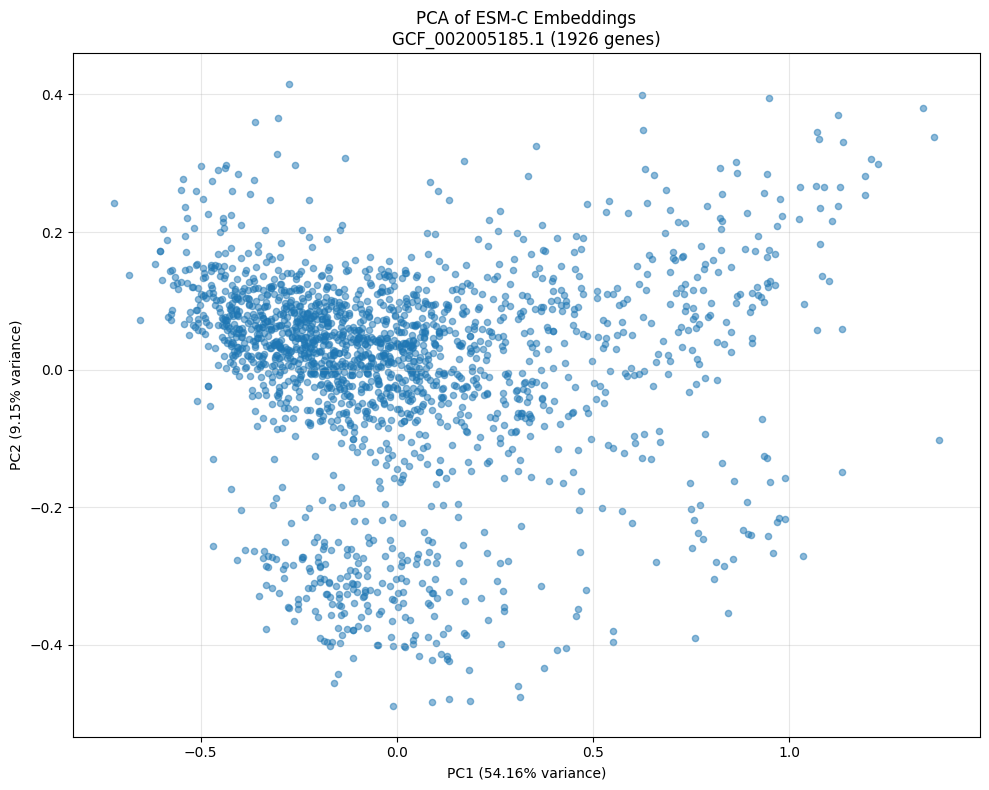

In [5]:
# Visualize embeddings with PCA
# Run PCA on embeddings
print("Running PCA...")
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.4f}")

# Plot
plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.5, s=20)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.title(f'PCA of ESM-C Embeddings\n{genome_id} ({len(embeddings)} genes)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [7]:
# Helper function to load embeddings for any genome
def load_genome_embeddings(genome_id, embeddings_dir="../data/refseq_esm_embeddings"):
    """
    Load ESM-C embeddings for a specific genome.
    
    Args:
        genome_id: Genome ID (e.g., 'GCF_000006985.1')
        embeddings_dir: Path to embeddings directory
        
    Returns:
        dict with 'embeddings', 'seq_ids', and 'genome_id'
    """
    embeddings_dir = Path(embeddings_dir)
    embedding_file = embeddings_dir / f"{genome_id}_esmc_embeddings_esmc_600m.npz"
    
    if not embedding_file.exists():
        raise FileNotFoundError(f"No embeddings found for {genome_id}")
    
    data = np.load(embedding_file, allow_pickle=True)
    
    return {
        'embeddings': data['embeddings'],
        'seq_ids': data['seq_ids'],
        'genome_id': genome_id,
        'n_genes': len(data['seq_ids']),
        'embedding_dim': data['embeddings'].shape[1]
    }

# Test the function
print("Testing helper function...")
test_data = load_genome_embeddings('GCF_000006985.1')
print(f"Loaded: {test_data['genome_id']}")
print(f"  Genes: {test_data['n_genes']}")
print(f"  Embedding dim: {test_data['embedding_dim']}")

Testing helper function...
Loaded: GCF_000006985.1
  Genes: 1978
  Embedding dim: 1152


In [10]:
test_data['embeddings'].shape

(1978, 1152)

In [ ]:
# Compute similarity between genes
# Get embeddings
embs = test_data['embeddings']
gene_ids = test_data['seq_ids']

# Compute pairwise cosine similarity for first 10 genes
n_genes = min(10, len(embs))
similarity_matrix = cosine_similarity(embs[:n_genes])

print(f"Cosine similarity matrix for first {n_genes} genes:")
print(f"Shape: {similarity_matrix.shape}\n")

# Visualize similarity matrix
plt.figure(figsize=(10, 8))
im = plt.imshow(similarity_matrix, cmap='viridis', aspect='auto')
plt.colorbar(im, label='Cosine Similarity')
plt.title(f'Gene Embedding Similarity Matrix\nFirst {n_genes} genes from {test_data["genome_id"]}')
plt.xlabel('Gene Index')
plt.ylabel('Gene Index')

# Add gene IDs as labels
tick_labels = [f"{i+1}" for i in range(n_genes)]
plt.xticks(range(n_genes), tick_labels)
plt.yticks(range(n_genes), tick_labels)
plt.tight_layout()
plt.show()

# Find most similar gene pairs
print("\nMost similar gene pairs (excluding self-similarity):")
np.fill_diagonal(similarity_matrix, -1)  # Ignore self-similarity
for i in range(min(5, n_genes)):
    for j in range(i+1, n_genes):
        sim = similarity_matrix[i, j]
        if sim > 0.8:  # Threshold for high similarity
            print(f"  {gene_ids[i]} <-> {gene_ids[j]}: {sim:.4f}")

In [11]:
# Load ALL embeddings from all genomes
print("Loading embeddings from all genomes...")
print(f"Total files to process: {len(embedding_files)}\n")

all_embeddings = []
all_gene_ids = []
all_genome_ids = []

# Load embeddings from all genomes
for emb_file in tqdm(embedding_files, desc="Loading embeddings"):
    genome_id = emb_file.stem.split("_esmc_embeddings")[0]
    
    try:
        data = np.load(emb_file, allow_pickle=True)
        embeddings = data['embeddings']
        seq_ids = data['seq_ids']
        
        # Store embeddings and metadata
        all_embeddings.append(embeddings)
        all_gene_ids.extend(seq_ids)
        all_genome_ids.extend([genome_id] * len(seq_ids))
        
    except Exception as e:
        print(f"Error loading {genome_id}: {e}")
        continue

# Concatenate all embeddings
print("\nConcatenating embeddings...")
all_embeddings = np.vstack(all_embeddings)
all_gene_ids = np.array(all_gene_ids)
all_genome_ids = np.array(all_genome_ids)

print(f"\nTotal embeddings loaded:")
print(f"  Shape: {all_embeddings.shape}")
print(f"  Total genes: {len(all_gene_ids):,}")
print(f"  Unique genomes: {len(np.unique(all_genome_ids)):,}")
print(f"  Memory usage: {all_embeddings.nbytes / 1e9:.2f} GB")

# Clean up
gc.collect()

Loading embeddings from all genomes...
Total files to process: 7664



Loading embeddings: 100%|██████████| 7664/7664 [42:44<00:00,  2.99it/s] 



Concatenating embeddings...

Total embeddings loaded:
  Shape: (29624903, 1152)
  Total genes: 29,624,903
  Unique genomes: 7,664
  Memory usage: 136.51 GB


4585

In [14]:
# Optional: Subsample for faster computation
# For initial testing, you may want to subsample the data
USE_SUBSAMPLE = True  # Set to False to use all data
SUBSAMPLE_SIZE = 100000  # Number of genes to sample

if USE_SUBSAMPLE and len(all_embeddings) > SUBSAMPLE_SIZE:
    print(f"Subsampling {SUBSAMPLE_SIZE:,} genes from {len(all_embeddings):,} total...")
    
    # Random subsample
    np.random.seed(42)
    indices = np.random.choice(len(all_embeddings), SUBSAMPLE_SIZE, replace=False)
    
    embeddings_subset = all_embeddings[indices]
    gene_ids_subset = all_gene_ids[indices]
    genome_ids_subset = all_genome_ids[indices]
    
    print(f"Subset shape: {embeddings_subset.shape}")
else:
    embeddings_subset = all_embeddings
    gene_ids_subset = all_gene_ids
    genome_ids_subset = all_genome_ids
    print("Using all embeddings (no subsampling)")
    
print(f"\nWorking with {len(embeddings_subset):,} genes")

Subsampling 100,000 genes from 29,624,903 total...
Subset shape: (100000, 1152)

Working with 100,000 genes


In [ ]:
# UMAP 
umap_dict = {}
for n in [15,25,50,100,200]:
    umap_reducer = umap.UMAP(
        n_neighbors=n,        # Balance between local and global structure
        n_components=2,        # 2D for visualization
        min_dist=0.1,          # Minimum distance between points in low-D space
        metric='cosine',       # Cosine distance for embeddings
        random_state=42,
        verbose=True
    )

    # Fit UMAP
    umap_dict[f"n_neighbors={n}"] = umap_reducer.fit_transform(embeddings_subset)

# np.save('results/refseq_embeddings_umap_2d.npy', embeddings_umap)

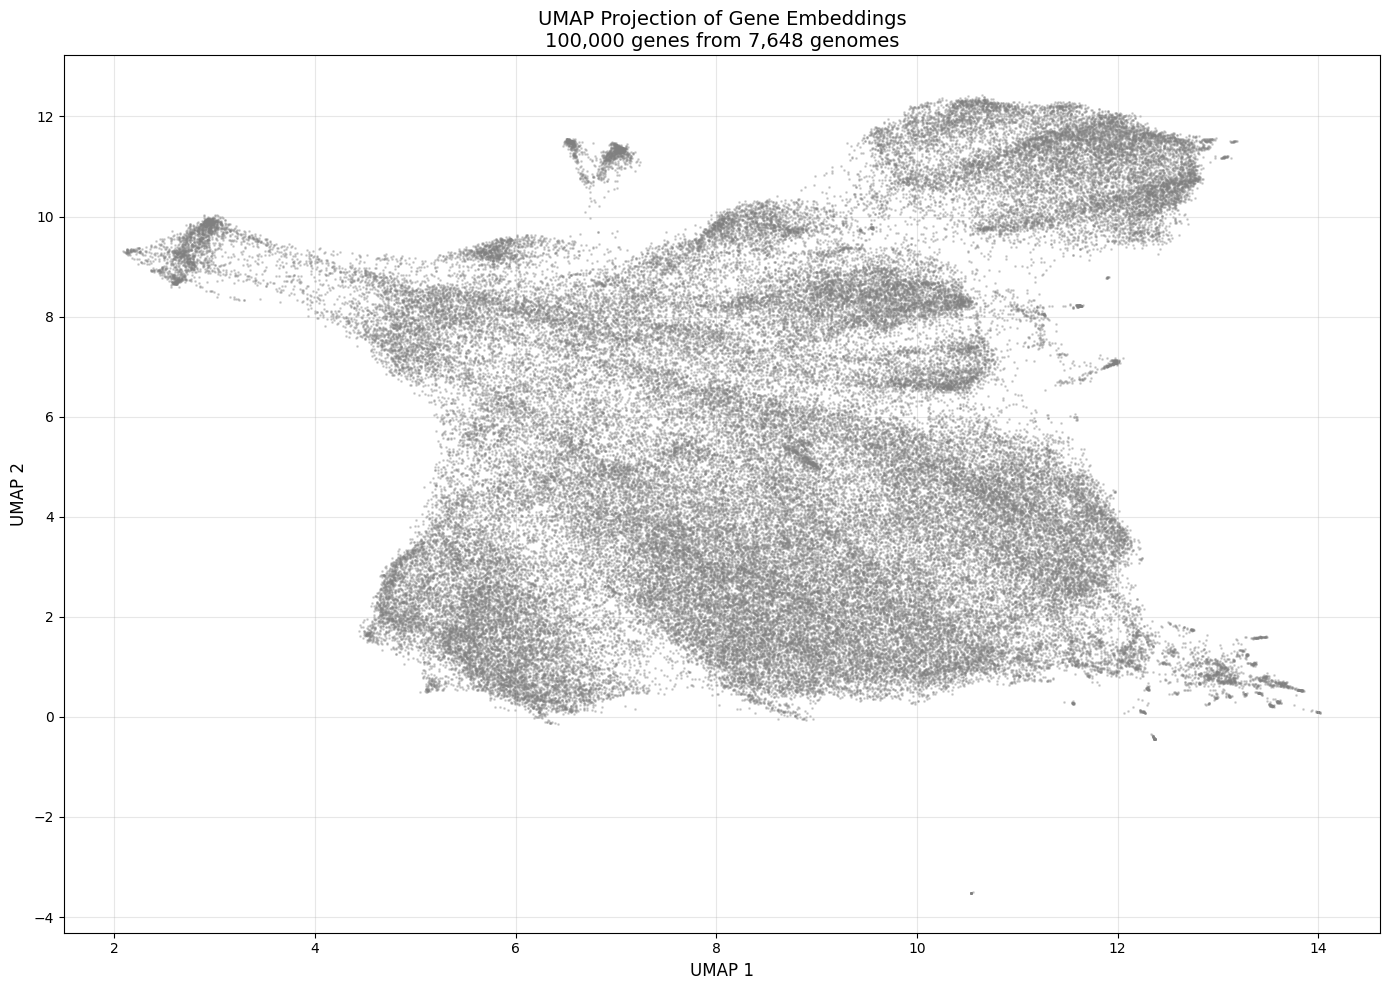

In [16]:
for n in [15,25,50,100,200]:
    # Visualize UMAP results
    plt.figure(figsize=(14, 10))

    # Plot all points
    plt.scatter(
        umap_dict[f"n_neighbors={n}"][:, 0], 
        umap_dict[f"n_neighbors={n}"][:, 1],
        c='gray',
        alpha=0.3,
        s=1,
        rasterized=True
    )

    plt.xlabel('UMAP 1', fontsize=12)
    plt.ylabel('UMAP 2', fontsize=12)
    plt.title(f'UMAP of Gene Embeddings\nn_neighbors={n}', 
              fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [ ]:
# ## t-SNE
# tsne = TSNE(
#     n_components=2,
#     perplexity=30,
#     learning_rate=200,
#     n_iter=1000,
#     metric='cosine',
#     random_state=42,
#     verbose=1
# )

# embeddings_tsne = tsne.fit_transform(embeddings_subset)

# np.save('results/refseq_embeddings_tsne_2d.npy', embeddings_tsne)

In [ ]:
# Clustering: HDBSCAN on original embeddings
# HDBSCAN is good for finding clusters of varying density
print("Running HDBSCAN clustering on original embeddings...")
print("This may take a while...\n")

# HDBSCAN clustering
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=50,      # Minimum genes per cluster
    min_samples=10,           # Conservative cluster formation
    metric='cosine',          # Use cosine distance
    cluster_selection_epsilon=0.0,
    core_dist_n_jobs=-1       # Use all CPU cores
)

# Fit on original high-dimensional embeddings (better than UMAP for clustering)
cluster_labels = clusterer.fit_predict(embeddings_subset)

# Get cluster statistics
n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
n_noise = list(cluster_labels).count(-1)

print(f"Clustering complete!")
print(f"  Number of clusters: {n_clusters}")
print(f"  Number of noise points: {n_noise:,} ({100*n_noise/len(cluster_labels):.1f}%)")
print(f"  Clustered points: {len(cluster_labels) - n_noise:,} ({100*(len(cluster_labels)-n_noise)/len(cluster_labels):.1f}%)")

# Cluster size distribution
unique_labels, counts = np.unique(cluster_labels[cluster_labels >= 0], return_counts=True)
print(f"\nCluster size statistics:")
print(f"  Mean: {counts.mean():.1f}")
print(f"  Median: {np.median(counts):.1f}")
print(f"  Min: {counts.min()}")
print(f"  Max: {counts.max()}")

print(f"\nTop 10 largest clusters:")
sorted_idx = np.argsort(counts)[::-1]
for i in range(min(10, len(counts))):
    idx = sorted_idx[i]
    print(f"  Cluster {unique_labels[idx]}: {counts[idx]:,} genes")

In [ ]:
# Visualize clusters on UMAP projection
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Left plot: Colored by cluster
ax = axes[0]
scatter = ax.scatter(
    embeddings_umap[:, 0],
    embeddings_umap[:, 1],
    c=cluster_labels,
    cmap='tab20',
    alpha=0.5,
    s=1,
    rasterized=True
)
ax.set_xlabel('UMAP 1', fontsize=12)
ax.set_ylabel('UMAP 2', fontsize=12)
ax.set_title(f'UMAP colored by HDBSCAN clusters\n{n_clusters} clusters identified', fontsize=14)
ax.grid(True, alpha=0.3)

# Right plot: Noise vs clustered
ax = axes[1]
is_noise = cluster_labels == -1
ax.scatter(
    embeddings_umap[is_noise, 0],
    embeddings_umap[is_noise, 1],
    c='lightgray',
    alpha=0.3,
    s=1,
    label=f'Noise ({n_noise:,})',
    rasterized=True
)
ax.scatter(
    embeddings_umap[~is_noise, 0],
    embeddings_umap[~is_noise, 1],
    c=cluster_labels[~is_noise],
    cmap='tab20',
    alpha=0.5,
    s=1,
    label=f'Clustered ({(~is_noise).sum():,})',
    rasterized=True
)
ax.set_xlabel('UMAP 1', fontsize=12)
ax.set_ylabel('UMAP 2', fontsize=12)
ax.set_title('Clustered vs Noise points', fontsize=14)
ax.legend(markerscale=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Analyze cluster composition: Which species contribute to each cluster?
print("Analyzing cluster composition across species...\n")

# Create a dataframe for analysis
cluster_df = pd.DataFrame({
    'gene_id': gene_ids_subset,
    'genome_id': genome_ids_subset,
    'cluster': cluster_labels,
    'umap_1': embeddings_umap[:, 0],
    'umap_2': embeddings_umap[:, 1]
})

# Filter out noise
clustered_df = cluster_df[cluster_df['cluster'] >= 0].copy()

print(f"Analyzing {len(clustered_df):,} clustered genes from {clustered_df['genome_id'].nunique()} genomes\n")

# For each cluster, count genes per genome
cluster_composition = []

for cluster_id in sorted(clustered_df['cluster'].unique()):
    cluster_genes = clustered_df[clustered_df['cluster'] == cluster_id]
    
    # Count genes per genome in this cluster
    genome_counts = cluster_genes['genome_id'].value_counts()
    
    cluster_composition.append({
        'cluster_id': cluster_id,
        'total_genes': len(cluster_genes),
        'n_genomes': len(genome_counts),
        'mean_genes_per_genome': genome_counts.mean(),
        'median_genes_per_genome': genome_counts.median(),
        'max_genes_per_genome': genome_counts.max(),
        'top_genome': genome_counts.index[0],
        'top_genome_count': genome_counts.iloc[0]
    })

composition_df = pd.DataFrame(cluster_composition)
composition_df = composition_df.sort_values('total_genes', ascending=False)

print("Top 10 clusters by size:")
print(composition_df.head(10).to_string(index=False))

# Save results
cluster_df.to_csv('gene_cluster_assignments.csv', index=False)
composition_df.to_csv('cluster_composition_summary.csv', index=False)
print("\n✓ Saved cluster_assignments.csv and cluster_composition_summary.csv")

In [ ]:
# Identify "core" functional gene clusters (shared across many species)
print("Identifying core gene clusters (shared across species)...\n")

total_genomes = clustered_df['genome_id'].nunique()

# Calculate genome prevalence for each cluster
composition_df['genome_prevalence'] = composition_df['n_genomes'] / total_genomes

# Define core clusters as those present in >50% of genomes
CORE_THRESHOLD = 0.5
core_clusters = composition_df[composition_df['genome_prevalence'] > CORE_THRESHOLD]

print(f"Total genomes analyzed: {total_genomes}")
print(f"Core threshold: >{CORE_THRESHOLD*100:.0f}% of genomes\n")
print(f"Found {len(core_clusters)} core gene clusters:\n")

if len(core_clusters) > 0:
    print(core_clusters[['cluster_id', 'total_genes', 'n_genomes', 'genome_prevalence', 
                         'mean_genes_per_genome']].to_string(index=False))
    
    # Visualize core clusters on UMAP
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Plot non-core clusters in gray
    non_core_mask = ~cluster_df['cluster'].isin(core_clusters['cluster_id'])
    ax.scatter(
        cluster_df.loc[non_core_mask, 'umap_1'],
        cluster_df.loc[non_core_mask, 'umap_2'],
        c='lightgray',
        alpha=0.2,
        s=1,
        label='Non-core clusters',
        rasterized=True
    )
    
    # Plot core clusters in color
    core_mask = cluster_df['cluster'].isin(core_clusters['cluster_id'])
    scatter = ax.scatter(
        cluster_df.loc[core_mask, 'umap_1'],
        cluster_df.loc[core_mask, 'umap_2'],
        c=cluster_df.loc[core_mask, 'cluster'],
        cmap='tab20',
        alpha=0.6,
        s=2,
        label='Core clusters',
        rasterized=True
    )
    
    ax.set_xlabel('UMAP 1', fontsize=12)
    ax.set_ylabel('UMAP 2', fontsize=12)
    ax.set_title(f'Core Gene Clusters (>{CORE_THRESHOLD*100:.0f}% genome prevalence)\n{len(core_clusters)} core clusters', 
                 fontsize=14)
    ax.legend(markerscale=10)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
else:
    print("No core clusters found with current threshold.")
    print("Try lowering CORE_THRESHOLD or adjusting clustering parameters.")

In [ ]:
# Examine specific cluster in detail
def examine_cluster(cluster_id, n_examples=20):
    """
    Examine a specific cluster in detail.
    
    Args:
        cluster_id: Cluster ID to examine
        n_examples: Number of example genes to show
    """
    cluster_genes = cluster_df[cluster_df['cluster'] == cluster_id]
    
    print(f"Cluster {cluster_id} Details")
    print("=" * 70)
    print(f"Total genes: {len(cluster_genes):,}")
    print(f"Unique genomes: {cluster_genes['genome_id'].nunique()}")
    print(f"Genome prevalence: {cluster_genes['genome_id'].nunique() / total_genomes * 100:.1f}%")
    
    # Genome distribution
    print(f"\nGenome distribution:")
    genome_counts = cluster_genes['genome_id'].value_counts()
    print(f"  Mean genes/genome: {genome_counts.mean():.1f}")
    print(f"  Median genes/genome: {genome_counts.median():.1f}")
    print(f"  Range: {genome_counts.min()} - {genome_counts.max()}")
    
    # Top genomes
    print(f"\nTop 10 genomes by gene count:")
    for i, (genome, count) in enumerate(genome_counts.head(10).items(), 1):
        print(f"  {i}. {genome}: {count} genes")
    
    # Example genes
    print(f"\nExample genes (first {n_examples}):")
    for i, row in cluster_genes.head(n_examples).iterrows():
        print(f"  {row['gene_id']} ({row['genome_id']})")
    
    # Visualize this cluster on UMAP
    fig, ax = plt.subplots(figsize=(12, 9))
    
    # Background
    ax.scatter(
        cluster_df['umap_1'],
        cluster_df['umap_2'],
        c='lightgray',
        alpha=0.1,
        s=1,
        rasterized=True
    )
    
    # Highlight this cluster
    ax.scatter(
        cluster_genes['umap_1'],
        cluster_genes['umap_2'],
        c='red',
        alpha=0.6,
        s=5,
        label=f'Cluster {cluster_id}',
        rasterized=True
    )
    
    ax.set_xlabel('UMAP 1', fontsize=12)
    ax.set_ylabel('UMAP 2', fontsize=12)
    ax.set_title(f'Cluster {cluster_id} Location\n{len(cluster_genes):,} genes', fontsize=14)
    ax.legend(markerscale=3)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return cluster_genes

# Example: Examine the largest cluster
if len(composition_df) > 0:
    largest_cluster_id = composition_df.iloc[0]['cluster_id']
    print(f"Examining largest cluster (ID: {largest_cluster_id})...\n")
    cluster_data = examine_cluster(int(largest_cluster_id), n_examples=15)
else:
    print("No clusters to examine")

In [ ]:
# Summary and Next Steps
print("=" * 80)
print("ANALYSIS SUMMARY")
print("=" * 80)

print(f"\n1. DATA LOADED:")
print(f"   - Total genes: {len(all_gene_ids):,}")
print(f"   - Total genomes: {len(np.unique(all_genome_ids)):,}")
print(f"   - Embedding dimension: {all_embeddings.shape[1]}")

if USE_SUBSAMPLE:
    print(f"\n2. SUBSAMPLING:")
    print(f"   - Used {len(embeddings_subset):,} genes for analysis")
    print(f"   - ({100*len(embeddings_subset)/len(all_embeddings):.1f}% of total)")

print(f"\n3. DIMENSIONALITY REDUCTION (UMAP):")
print(f"   - Reduced {all_embeddings.shape[1]}D → 2D")
print(f"   - Saved to: embeddings_umap_2d.npy")

print(f"\n4. CLUSTERING (HDBSCAN):")
print(f"   - Clusters found: {n_clusters}")
print(f"   - Clustered genes: {len(cluster_labels) - n_noise:,} ({100*(len(cluster_labels)-n_noise)/len(cluster_labels):.1f}%)")
print(f"   - Noise points: {n_noise:,} ({100*n_noise/len(cluster_labels):.1f}%)")

if len(core_clusters) > 0:
    print(f"\n5. CORE GENE CLUSTERS (>{CORE_THRESHOLD*100:.0f}% genome prevalence):")
    print(f"   - Core clusters: {len(core_clusters)}")
    print(f"   - These represent conserved functional genes across species")

print(f"\n6. OUTPUT FILES:")
print(f"   ✓ gene_cluster_assignments.csv - All gene→cluster mappings")
print(f"   ✓ cluster_composition_summary.csv - Cluster statistics")
print(f"   ✓ embeddings_umap_2d.npy - UMAP coordinates")

print("\n" + "=" * 80)
print("NEXT STEPS FOR FUNCTIONAL ANNOTATION")
print("=" * 80)
print("""
To identify what functions each cluster represents:

1. Select genes from a cluster (use examine_cluster function)

2. Get protein sequences for those genes from:
   data/refseq_gene_annotations/{genome_id}_prodigal_proteins.faa

3. Run functional annotation:
   - BLAST against known databases (UniProt, KEGG, etc.)
   - Use tools like eggNOG-mapper, InterProScan
   - Look for conserved domains with CD-Search

4. Examine core clusters first - these are likely:
   - Housekeeping genes (ribosomal proteins, DNA/RNA polymerase)
   - Essential metabolic enzymes
   - Conserved structural proteins

5. Compare cluster membership across taxonomic groups
   - Are certain clusters specific to certain phyla?
   - Do clusters correlate with metabolic capabilities?

Use examine_cluster(cluster_id) to dive deeper into any cluster!
""")